# Regression Analysis
## Part A

Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and ridge, Lasso regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
   
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("uber.csv")

In [3]:
df = df.drop(["Unnamed: 0", "key"], axis=1)

In [4]:
df = df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_datetime    199999 non-null  object 
 2   pickup_longitude   199999 non-null  float64
 3   pickup_latitude    199999 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


In [6]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [7]:
# Convert datetime
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["hour"] = df["pickup_datetime"].dt.hour
df["weekday"] = df["pickup_datetime"].dt.weekday

In [8]:
# Drop original datetime
df = df.drop("pickup_datetime", axis=1)

In [9]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two GPS points (in km)
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

In [10]:
df["distance_km"] = haversine_vectorized(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

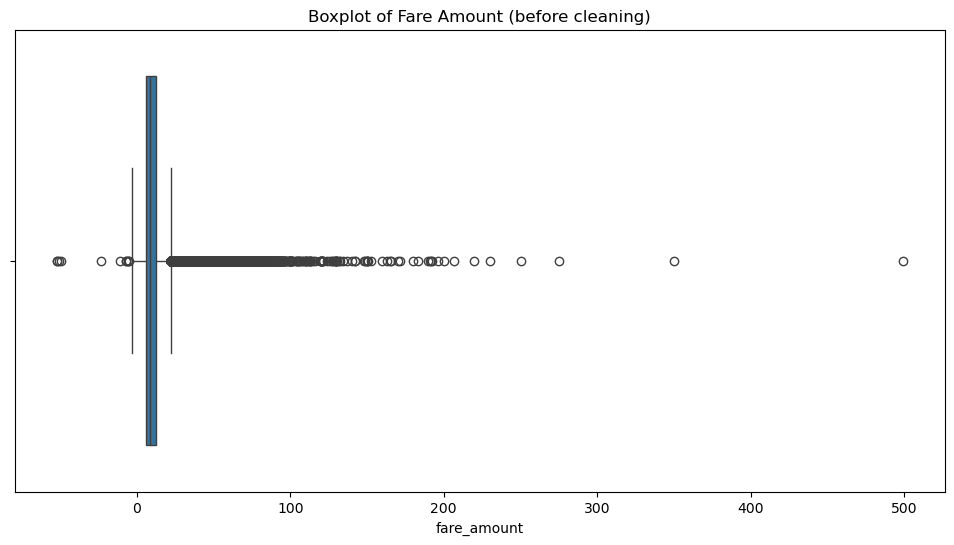

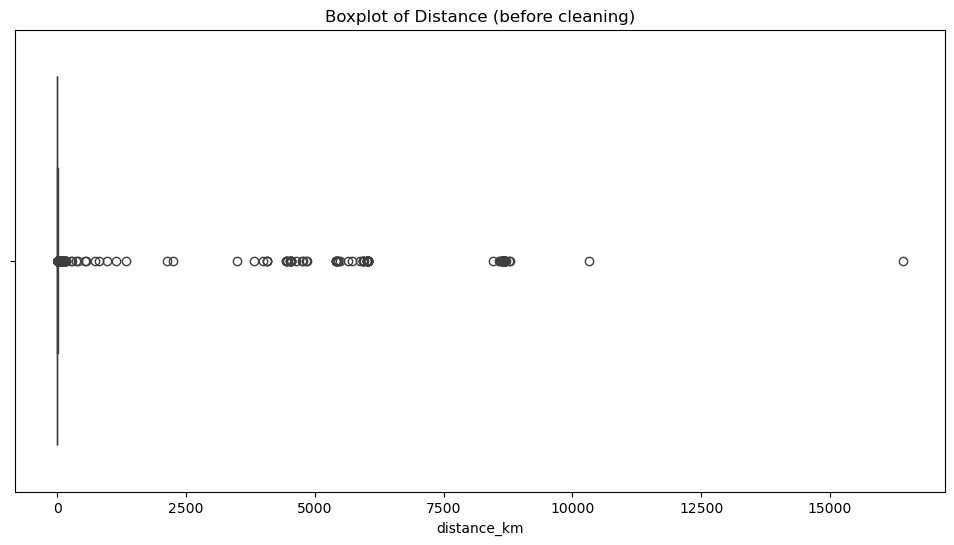

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df["fare_amount"])
plt.title("Boxplot of Fare Amount (before cleaning)")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=df["distance_km"])
plt.title("Boxplot of Distance (before cleaning)")
plt.show()

In [12]:
# Remove negative or too high fares
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 500)]

In [13]:
# Remove zero or very large distances
df = df[(df["distance_km"] > 0) & (df["distance_km"] < 100)]

In [14]:
# Remove unrealistic passenger counts
df = df[(df["passenger_count"] > 0) & (df["passenger_count"] <= 6)]

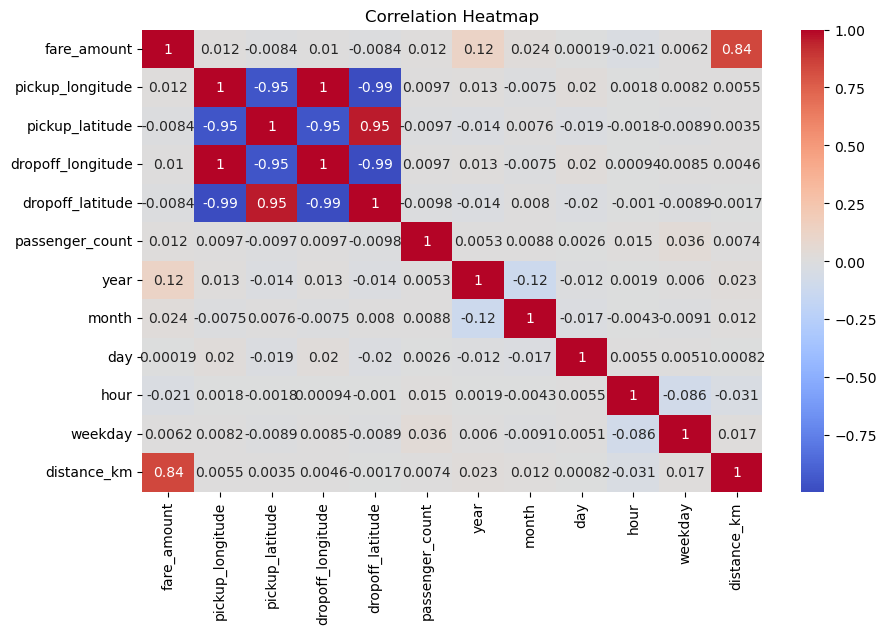

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [16]:
X = df.drop("fare_amount", axis=1)
y = df["fare_amount"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

In [19]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {"R2": r2, "RMSE": rmse}

In [20]:
results_df = pd.DataFrame(results).T
print(results_df)

                        R2      RMSE
LinearRegression  0.679044  5.607820
Ridge             0.679034  5.607907
Lasso             0.676377  5.631072
